In [1]:
import os
import yaml
import pypsa

import tz_pypsa as tza
from tz_pypsa.model import Model

## Build a base network from TZA-PyPSA-ASEAN

In [7]:
network = (
    Model.load_model(
        'ASEAN', 
        frequency = '1h',
        select_nodes = ['MYSPE'], 
        years = [2030],
        backstop = False,
        set_global_constraints = False,
    )
)

## Define function to build a CFE network

In [ ]:
def PrepareNetworkForCFE(network, buses_with_ci_load):
    '''
    
    In this function, we take a PyPSA network and create a virtual subsystem representing 
        a C&I asset. Here, we loop through a set of buses in our brownfield network where
        we want to add a C&I load. We create a subsystem attached to each define bus, as 
        we do in the demo script / schematic.

    '''

    clean_carriers = ['photovoltaic-unspecified']
    clean_storages = ['lithium-ion']

    n = network.copy()

    # loop and add buses
    for bus in buses_with_ci_load:

        # define C&I bus
        ci_bus = f'{bus} C&I Grid'
        ci_storage = f'{bus} C&I Storage'

        # add bus for C&I system
        n.add(
            "Bus",
            ci_bus,
            x = n.buses.x.iloc[0] + 1,
            y = n.buses.y.iloc[0] + 1,       
        )

        # add bus for C&I storage
        n.add(
            "Bus",
            ci_storage,
            x = n.buses.x.iloc[0] - 1,
            y = n.buses.y.iloc[0] - 1,
        )

        # add C&I load
        n.add(
            "Load",
            f'{bus} C&I Load',
            bus = ci_bus,
            p_set = n.loads_t.p_set[bus] * 0.1,
        )

        # add clean generator for PPA
        n.add(
            "Generator",
            f'{bus} PPA Generation',
            bus = ci_bus,
            carrier = 'C&I Clean',
            p_nom = 0,
            p_nom_extendable = True,
            capital_cost = 1e12,
            marginal_cost = 1e3,
            p_max_pu = n.generators_t.p_max_pu.filter(regex='photo').values.flatten(),
        )

        # add clean storage for PPA
        n.add(
            "StorageUnit",
            f"{bus} PPA Storage",
            bus=ci_storage,
            p_nom=0,
            p_nom_extendable=True,
            cyclic_state_of_charge=True,
            capital_cost=1e9,
            marginal_cost=0,
            max_hours=4,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
        )

        # add links to connect Bus <-> C&I System
        n.add(
            "Link",
            f"{bus} Grid Imports",
            bus0=bus, 
            bus1=ci_bus, 
            p_nom=1e12,
            marginal_cost=1,
        )

        n.add(
            "Link",
            f"{bus} Grid Exports",
            bus0=ci_bus, 
            bus1=bus, 
            p_nom=1e12,
            marginal_cost=1,
        )

        # add links to connect C&I System <-> Storage
        n.add(
            "Link",
            f"{bus} StorageCharge",
            bus0=ci_bus, 
            bus1=ci_storage, 
            p_nom=0,
            p_nom_extendable=True,
            marginal_cost=1,
        )

        n.add(
            "Link",
            f"{bus} StorageDischarge",
            bus0=ci_storage, 
            bus1=ci_bus, 
            p_nom=0,
            p_nom_extendable=True,
            marginal_cost=1,
        )

    return n

## Run a brownfield network simulation

In [15]:
brownfield = network.copy()

# prep for CFE (though nothing happens on C&I system in brownfield)
brownfield = PrepareNetworkForCFE(network)

# optimise
brownfield.optimize(solver_name='gurobi')

## Run a cfe simulation

In [129]:
cfe = PrepareNetworkForCFE(network)

cfe.optimize.create_model()

CFE_TARGET = 0.95
MAXIMUM_EXCESS = 0.2

# fetch necessary variables to implement CFE

CI_Demand = (
    cfe.loads_t.p_set.filter(regex='C&I Load').values.flatten()
)

CI_StorageCharge = (
    cfe.model.variables['Link-p'].sel(
        Link=[i for i in cfe.links.index if 'StorageCharge' in i]
    )
)

CI_StorageDischarge = (
    cfe.model.variables['Link-p'].sel(
        Link=[i for i in cfe.links.index if 'StorageDischarge' in i]
    )
)

CI_GridExport = (
    cfe.model.variables['Link-p'].sel(
        Link=[i for i in cfe.links.index if 'Exports' in i]
    )
)

CI_GridImport = (
    cfe.model.variables['Link-p'].sel(
        Link=[i for i in cfe.links.index if 'Imports' in i]
    )
)

CI_PPA = (
    cfe.model.variables['Generator-p'].sel(
        Generator=[i for i in cfe.generators.index if 'PPA' in i]
    )
)

# Constraint 1: Hourly matching
# ---------------------------------------------------------------

cfe.model.add_constraints(
    ((CI_StorageCharge - CI_StorageDischarge) + CI_Demand) == CI_PPA - CI_GridExport + CI_GridImport,
    name = 'hourly_matching_constraint',
)

# Constraint 2: CFE target
# ---------------------------------------------------------------

cfe.model.add_constraints(
    (CI_PPA - CI_GridExport + CI_GridImport * 0.3).sum() >= ((CI_StorageCharge - CI_StorageDischarge) + CI_Demand).sum() * CFE_TARGET,
    name = 'CFE_target_constraint',
)

# Constraint 3: Excess
# ---------------------------------------------------------------
cfe.model.add_constraints(
    CI_GridExport.sum() <= sum(CI_Demand) * MAXIMUM_EXCESS,
    name = 'total_excess_constraint',
)

cfe.optimize.solve_model(solver_name='gurobi', solver_options={'log_to_console': False})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - log_to_console: False


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-24


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-09-24
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 55.92it/s]
INFO:linopy.io: Writing time: 1.57s


Read LP format model from file /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/linopy-problem-z4fk36t2.lp


INFO:gurobipy.gurobipy:Read LP format model from file /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/linopy-problem-z4fk36t2.lp


Reading time = 0.59 seconds


INFO:gurobipy.gurobipy:Reading time = 0.59 seconds


obj: 595667 rows, 183965 columns, 1160118 nonzeros


INFO:gurobipy.gurobipy:obj: 595667 rows, 183965 columns, 1160118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 183965 primals, 595667 duals
Objective: 1.09e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, hourly_matching_constraint, CFE_target_constraint, total_excess_constraint were not assigned to the network.


('ok', 'optimal')

## Post-processing

In [112]:
brownfield.statistics.energy_balance() / 1e5

component    carrier  bus_carrier
Load         -        AC            -1656.644000
Generator    Coal     AC             1068.079927
             Gas      AC              439.882140
             Hydro    AC              136.086071
             Solar    AC               20.903664
StorageUnit  Battery  AC               -8.307803
dtype: float64

In [113]:
cfe.statistics.energy_balance()  / 1e5

component    carrier  bus_carrier
Load         -        AC            -1656.644000
Generator    Coal     AC             1068.079927
             Gas      AC              439.882140
             Hydro    AC              136.086071
             Solar    AC               20.903664
StorageUnit  Battery  AC               -8.307803
dtype: float64

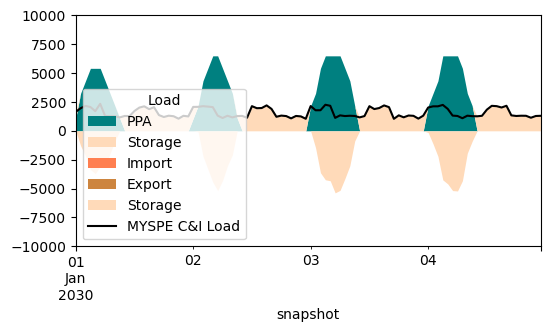

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_dispatch(n, ci_label='C&I', timesteps=24):

    gen = n.generators_t.p.filter(regex=ci_label).sum(axis=1).iloc[0:timesteps].to_frame('PPA')

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.filter(regex=ci_label).sum(axis=1).iloc[0:timesteps].to_frame('Storage')
        
    imports = n.links_t.p0.filter(regex='Import').sum(axis=1).iloc[0:timesteps].to_frame('Import')
    exports = n.links_t.p0.filter(regex='Export').sum(axis=1).iloc[0:timesteps].to_frame('Export').mul(-1)

    p_by_carrier = pd.concat([gen, sto, imports, exports], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color_dict = {
        'PPA' : 'teal',
        'Storage' : 'peachpuff',
        'Import' : 'coral',
        'Export' : 'peru',
    }

    color = (
        p_by_carrier
        .columns
        .map(color_dict)
    )

    p_by_carrier.where(p_by_carrier > 0).iloc[0:timesteps].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1)

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(color_dict),
        )

    n.loads_t.p_set.iloc[0:timesteps].filter(regex='C&I Load').plot(ax=ax, c="k")

    ax.set_ylim([-1e4,1e4])


plot_dispatch(cfe, ci_label='PPA', timesteps=24*4)